### Load the trainer

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch

from sam3.train.masks_ops import mask_iom
from utils import plot_mask, COLORS

Enabled the use of perflib.


In [4]:
# turn on tfloat32 for Ampere GPUs
# https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True

# use bfloat16 for the entire notebook
torch.autocast("cuda", dtype=torch.bfloat16).__enter__()


In [ ]:
def run_inference_on_image(image, text_prompt, model, processor, output_prob_thresh=0.5):
    """Run inference on a single image with text prompt"""
    # Create inference state for this image
    inference_state = processor(image, instance_prompt=False)

    # Add text prompt
    processor.reset_state(inference_state)
    processor.add_prompt(inference_state, text_str=text_prompt, instance_prompt=False)

    # Run inference
    model.run_inference(inference_state)

    # Get output with the specified threshold
    output = processor.postprocess_output(inference_state, output_prob_thresh=output_prob_thresh)

    return output

def clean_mask_iom_nms(pred_scores, pred_masks, mask_threshold=0.5, score_thresh=0.5, iou_thresh=0.5):
    keep = pred_scores.squeeze(-1) >= score_thresh
    if keep.sum() < 1:
        return pred_scores, pred_masks
    maskids = torch.where(keep)[0]

    scores_subset = pred_scores[keep]
    masks_subset = pred_masks[keep].sigmoid() > mask_threshold

    N = masks_subset.size(0)

    # sort by score (desc), and compute IoM matrix on the sorted masks
    order = scores_subset[:,0].argsort(descending=True)
    masks_sorted = masks_subset[order]
    pairwise_iom = mask_iom(masks_sorted, masks_sorted)

    keep_mask = torch.zeros(N, dtype=torch.bool, device=masks_subset.device)
    suppressed = torch.zeros(N, dtype=torch.bool, device=masks_subset.device)

    for i in range(N):
        if suppressed[i]:
            continue
        keep_mask[i] = True

        # suppress all j>i that have IoM > threshold with mask i
        sup = pairwise_iom[i] > iou_thresh
        # only affect the *future* candidates
        if i + 1 < N:
            suppressed[i + 1:] |= sup[i + 1:]

    # map back to original indices
    kept_sorted_idx = torch.nonzero(keep_mask, as_tuple=False).squeeze(1)
    maskids_keep_order = order[kept_sorted_idx]
    maskids_keep = torch.tensor([maskids[i] for i in maskids_keep_order], device=masks_subset.device)

    new_scores, new_masks = pred_scores[maskids_keep], pred_masks[maskids_keep]

    return new_scores, new_masks


def multi_crop_forward_sam3(whole_image, text_prompt, model, processor, K_axis=4, output_prob_thresh=0.5, iom_threshold=0.5):
    """Multi-crop forward pass adapted for SAM3 processor interface"""

    width, height = whole_image.size

    image_crop_list = []

    # Calculate the size of each crop with overlap
    crop_width = width // K_axis
    crop_height = height // K_axis

    # Iterate over the grid and crop the image with overlap
    for i in range(K_axis-1):
        for j in range(K_axis-1):
            # Define the box coordinates for each crop
            left = j * width // K_axis
            upper = i * height // K_axis
            right = (j + 2) * crop_width
            lower = (i + 2) * crop_height

            # Ensure we don't go beyond image boundaries
            right = min(right, width)
            lower = min(lower, height)

            # Crop the image
            crop = whole_image.crop((left, upper, right, lower))
            image_crop_list.append((crop, (left, upper, right, lower)))

    all_crop_masks = []

    # Process each crop
    for crop_idx, (image_crop, (left, upper, right, lower)) in enumerate(image_crop_list):
        crop_out = run_inference_on_image(image_crop, text_prompt, model, processor, output_prob_thresh)

        if 'out_binary_masks' in crop_out and len(crop_out['out_binary_masks']) > 0:
            for i, mask in enumerate(crop_out['out_binary_masks']):
                confidence_score = crop_out['out_probs'][i] if i < len(crop_out['out_probs']) else 0.5
                bbox_xywh = crop_out['out_boxes_xywh'][i] if i < len(crop_out['out_boxes_xywh']) else None
                all_crop_masks.append({
                    'mask': mask,
                    'crop_bounds': (left, upper, right, lower),
                    'confidence': confidence_score,
                    'bbox_xywh': bbox_xywh
                })

    # Convert all crop masks to full image coordinates
    full_image_masks = []

    for crop_mask_info in all_crop_masks:
        mask = crop_mask_info['mask']
        left, upper, right, lower = crop_mask_info['crop_bounds']

        # Create full-size mask
        full_mask = np.zeros((height, width), dtype=bool)

        # Resize mask to match crop dimensions if needed
        crop_height_actual = lower - upper
        crop_width_actual = right - left

        if mask.shape != (crop_height_actual, crop_width_actual):
            from PIL import Image as PILImage
            mask_pil = PILImage.fromarray(mask.astype(np.uint8) * 255)
            mask_pil = mask_pil.resize((crop_width_actual, crop_height_actual))
            mask = np.array(mask_pil) > 127  # Ensure binary mask after resizing

        # Ensure mask is binary (0/1) before placing in full_mask
        mask = mask.astype(bool)
        full_mask[upper:lower, left:right] = mask
        full_image_masks.append(full_mask)

    if not full_image_masks:
        return []

    device = next(model.parameters()).device
    mask_tensors = []
    for mask in full_image_masks:
        # Ensure mask is float32 and contiguous
        mask = np.ascontiguousarray(mask.astype(np.float32))  # 0.0/1.0 float32
        mask_tensor = torch.from_numpy(mask).to(device)
        mask_tensors.append(mask_tensor)
    mask_tensor_stack = torch.stack(mask_tensors)


    confidence_scores = []
    for crop_mask_info in all_crop_masks:
        confidence_scores.append(crop_mask_info['confidence'])
    scores_tensor = torch.tensor(confidence_scores, device=device, dtype=torch.float32)


    final_scores, final_masks = clean_mask_iom_nms(
        scores_tensor.unsqueeze(-1), mask_tensor_stack,
        score_thresh=0.0,
        iou_thresh=iom_threshold
    )

    # Convert back to numpy
    final_masks_np = []
    for mask_tensor in final_masks:
        mask_np = mask_tensor.cpu().numpy()
        final_masks_np.append(mask_np)

    return final_masks_np

### Build the model

In [33]:
# Build Model
from sam3 import build_sam3_image_model

sam3_root = "/home/marksm/sam3"

bpe_path = f"{sam3_root}/assets/bpe_simple_vocab_16e6.txt.gz"
checkpoint_path = f"{sam3_root}/assets/checkpoints/checkpoint_model_only_presence_0_5.pt"
has_presence_token = True

model = build_sam3_image_model(bpe_path=bpe_path, checkpoint_path=checkpoint_path, has_presence_token=has_presence_token)

# Load and process image
from sam3.model.sam3_image_processor import Sam3Processor

text_prompt = "person"
OUTPUT_PROB_THRESH = 0.5

image_path = '/home/marksm/pixmo_count_example.jpg'
image = Image.open(image_path).convert("RGB")
processor = Sam3Processor()


### Count the objects without Multicrop

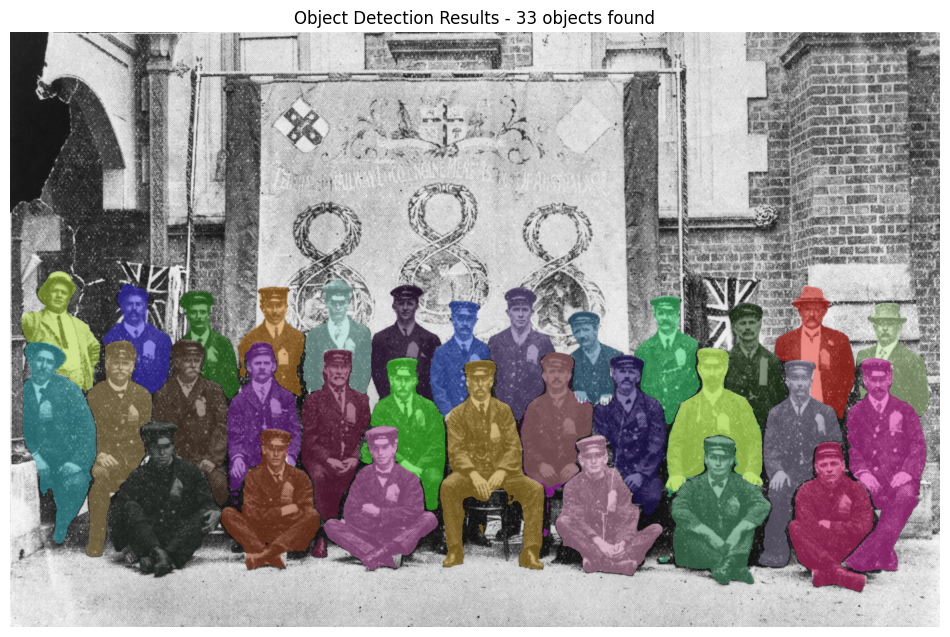

In [39]:
out = run_inference_on_image(image, text_prompt, model, processor, output_prob_thresh=OUTPUT_PROB_THRESH)
binary_masks = out["out_binary_masks"]
plt.figure(figsize=(12, 8))
plt.imshow(image)
for m_idx, mask in enumerate(binary_masks):
    plot_mask(mask, color=COLORS[m_idx % len(COLORS)])
plt.axis('off')
plt.title(f"Object Detection Results - {len(binary_masks)} objects found")
plt.show()



In [40]:
### Count the objects with Multicrop

Multi-crop processing with K_axis=4
Processing crop 1/9
Processing crop 2/9
Processing crop 3/9
Processing crop 4/9
Processing crop 5/9
Processing crop 6/9
Processing crop 7/9
Processing crop 8/9
Processing crop 9/9


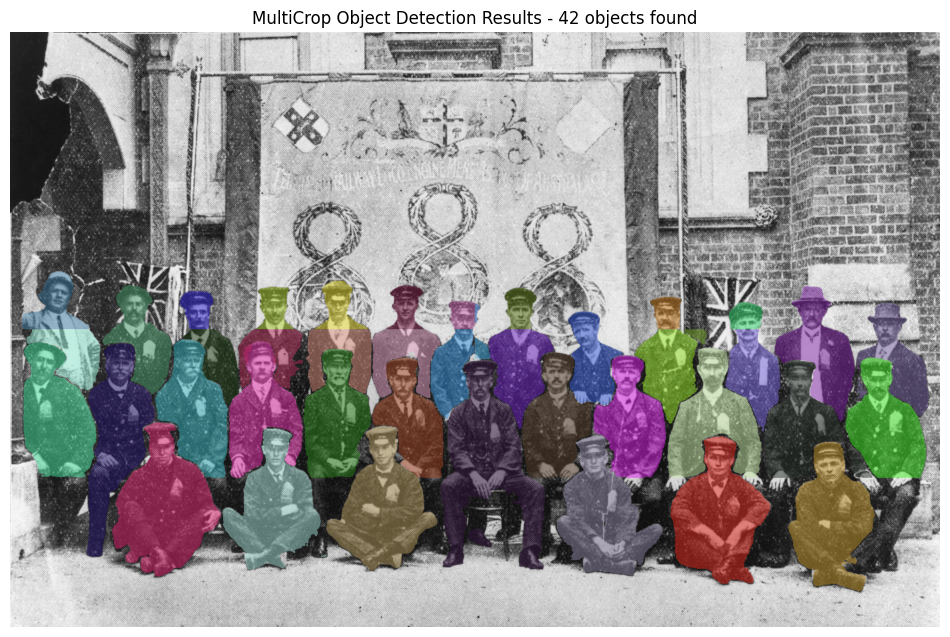

In [41]:
K_AXIS = 4

binary_masks = multi_crop_forward_sam3(
    whole_image=image,
    text_prompt=text_prompt,
    model=model,
    processor=processor,
    K_axis=K_AXIS,
    output_prob_thresh=OUTPUT_PROB_THRESH
)
# plotting
plt.figure(figsize=(12, 8))
plt.imshow(image)
for m_idx, mask in enumerate(binary_masks):
    plot_mask(mask, color=COLORS[m_idx % len(COLORS)])
plt.axis('off')
plt.title(f"MultiCrop Object Detection Results - {len(binary_masks)} objects found")
plt.show()